In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
responses = pd.read_csv("dataset/responses.csv")
questions = pd.read_csv("dataset/questions.csv")
reports = pd.read_csv("dataset/reports.csv")
measures = pd.read_csv("dataset/measures.csv")
state_results = pd.read_csv("dataset/state_results.csv")

print(responses.shape, questions.shape, reports.shape, measures.shape, state_results.shape)

(43219, 5) (19, 6) (9, 3) (10, 3) (4580, 6)


In [3]:
responses.columns = responses.columns.str.lower().str.replace(" ", "_")
questions.columns = questions.columns.str.lower().str.replace(" ", "_")
reports.columns = reports.columns.str.lower().str.replace(" ", "_")
measures.columns = measures.columns.str.lower().str.replace(" ", "_")
state_results.columns = state_results.columns.str.lower().str.replace(" ", "_")

In [4]:
responses.columns

Index(['release_period', 'state', 'facility_id', 'completed_surveys',
       'response_rate_(%)'],
      dtype='object')

In [5]:
questions.columns

Index(['question_num', 'measure_id', 'question', 'bottom-box_answer',
       'middle-box_answer', 'top-box_answer'],
      dtype='object')

In [6]:
reports.columns

Index(['release_period', 'start_date', 'end_date'], dtype='object')

In [7]:
measures.columns

Index(['measure_id', 'measure', 'type'], dtype='object')

In [8]:
state_results.columns

Index(['release_period', 'state', 'measure_id', 'bottom-box_percentage',
       'middle-box_percentage', 'top-box_percentage'],
      dtype='object')

## Data Cleaning

### Cleaning responses

In [9]:
responses["completed_surveys"] = pd.to_numeric(
    responses["completed_surveys"],
    errors="coerce"
)

In [10]:
responses["response_rate"] = (
    responses["response_rate_(%)"]
    .astype(str)
    .str.replace("%", "", regex=False)
)

responses["response_rate"] = pd.to_numeric(
    responses["response_rate"],
    errors="coerce"
)

responses.drop(columns=["response_rate_(%)"], inplace=True)

### Cleaning state_results

In [11]:
state_results["top_box_pct"] = pd.to_numeric(
    state_results["top-box_percentage"], 
    errors="coerce"
)

In [12]:
state_results = state_results.dropna(subset=["top_box_pct"])

### Cleaning questions

In [13]:
questions["measure_id"] = questions["measure_id"].str.strip()

### Cleaning measures

In [14]:
measures["measure_id"] = measures["measure_id"].str.strip()

### Cleaning reports

In [15]:
reports["start_date"] = pd.to_datetime(reports["start_date"], errors="coerce")
reports["end_date"] = pd.to_datetime(reports["end_date"], errors="coerce")

## Building the Satisfaction Fact Table

In [16]:
state_q = state_results.merge(
    questions,
    on="measure_id",
    how="left"
)

In [17]:
state_q[['measure_id', 'question']].drop_duplicates().head()

,measure_id,question
0,H_CLEAN_HSP,"During this hospital stay, how often were your..."
1,H_COMP_1,"During this hospital stay, how often did nurse..."
2,H_COMP_1,"During this hospital stay, how often did nurse..."
3,H_COMP_1,"During this hospital stay, how often did nurse..."
4,H_COMP_2,"During this hospital stay, how often did docto..."


In [18]:
state_q = state_q.merge(
    measures,
    on='measure_id',
    how='left'
)

In [20]:
state_q['question'].unique()

array(['During this hospital stay, how often were your room and bathroom kept clean? ',
       'During this hospital stay, how often did nurses treat you with courtesy and respect? ',
       'During this hospital stay, how often did nurses listen carefully to you? ',
       'During this hospital stay, how often did nurses explain things in a way you could understand? ',
       'During this hospital stay, how often did doctors treat you with courtesy and respect? ',
       'During this hospital stay, how often did doctors listen carefully to you? ',
       'During this hospital stay, how often did doctors explain things in a way you could understand? ',
       'During this hospital stay, after you pressed the call button, how often did you get help as soon as you wanted it? ',
       'How often did you get help in getting to the bathroom or in using a bedpan as soon as you wanted? ',
       'Before giving you any new medicine, how often did hospital staff tell you what the medicine was 

In [25]:
key_measures = [
    "H_COMP_1",   # Nurse communication
    "H_COMP_2",   # Doctor communication
    "H_COMP_3",   # Staff responsiveness
    "H_CLEAN",    # Cleanliness
    "H_DISCH",    # Discharge info
    "H_RECMND",   # Recommend hospital
    "H_OVERALL"   # Overall rating
]

state_q = state_q[state_q["measure_id"].isin(key_measures)]

In [26]:
state_pivot = state_q.pivot_table(
    index=['state', 'release_period'],
    columns="measure_id",
    values="top_box_pct",
    aggfunc="mean"
).reset_index()

In [27]:
state_pivot.shape

(458, 6)

In [28]:
state_pivot.head()

measure_id,state,release_period,H_COMP_1,H_COMP_2,H_COMP_3,H_RECMND
0,AK,07_2015,74.0,75.0,68.0,70.0
1,AK,07_2016,78.0,82.0,73.0,69.0
2,AK,07_2017,76.0,80.0,70.0,69.0
3,AK,07_2018,79.0,80.0,73.0,74.0
4,AK,07_2019,80.0,79.0,69.0,66.0


In [30]:
state_pivot["communication_score"] = state_pivot[
    ["H_COMP_1", "H_COMP_2"]
].mean(axis=1)

In [31]:
state_pivot["experience_score"] = state_pivot[
    ["H_COMP_3"]
].mean(axis=1)

In [32]:
state_pivot["executive_satisfaction_index"] = (
    state_pivot["H_RECMND"] * 0.5 + 
    state_pivot["communication_score"] * 0.3 + 
    state_pivot["experience_score"] * 0.2
)

In [33]:
state_pivot.rename(columns={
    "H_COMP_1": "nurse_communication",
    "H_COMP_2": "doctor_communication",
    "H_COMP_3": "staff_responsiveness",
    "H_RECMND": "recommend_hospital"
}, inplace=True)

In [34]:
state_pivot[
    [
        "recommend_hospital",
        "communication_score",
        "experience_score",
        "executive_satisfaction_index"
    ]
]

measure_id,recommend_hospital,communication_score,experience_score,executive_satisfaction_index
0,70.0,74.5,68.0,70.95
1,69.0,80.0,73.0,73.10
2,69.0,78.0,70.0,71.90
3,74.0,79.5,73.0,75.45
4,66.0,79.5,69.0,70.65
...,...,...,...,...
453,70.0,80.0,76.0,74.20
454,71.0,82.5,78.0,75.85
455,70.0,82.5,78.0,75.35
456,69.0,81.0,74.0,73.60


In [36]:
# The dataset did not include overall rating scores at the state level, so I constructed an Executive Satisfaction Index using recommendation 
# likelihood, communication quality, and staff responsiveness, which are validated HCAHPS top-box indicators.

In [37]:
state_pivot.head()

measure_id,state,release_period,nurse_communication,doctor_communication,staff_responsiveness,recommend_hospital,communication_score,experience_score,executive_satisfaction_index
0,AK,07_2015,74.0,75.0,68.0,70.0,74.5,68.0,70.95
1,AK,07_2016,78.0,82.0,73.0,69.0,80.0,73.0,73.10
2,AK,07_2017,76.0,80.0,70.0,69.0,78.0,70.0,71.90
3,AK,07_2018,79.0,80.0,73.0,74.0,79.5,73.0,75.45
4,AK,07_2019,80.0,79.0,69.0,66.0,79.5,69.0,70.65


# EDA Question

### 1. How does patient satisfaction vary across states?

In [38]:
state_perf = (
    state_pivot
    .groupby("state")["executive_satisfaction_index"]
    .mean()
    .sort_values()
)
state_perf.head(10)

state
DC    63.222222
MD    67.606250
NJ    67.827778
NY    68.238889
NV    68.533333
NM    69.288889
FL    69.661111
CA    70.100000
AZ    70.488889
DE    71.272222
Name: executive_satisfaction_index, dtype: float64

### 2. Which dimension drives satisfaction the most?

In [39]:
state_pivot[
    ["communication_score", "experience_score", "recommend_hospital"]
].corr()

measure_id,communication_score,experience_score,recommend_hospital
measure_id,,,
communication_score,1.000000,0.864061,0.799704
experience_score,0.864061,1.000000,0.779147
recommend_hospital,0.799704,0.779147,1.000000


### 3. Are improvements consistent over time?

In [40]:
trend = (
    state_pivot
    .groupby("release_period")["executive_satisfaction_index"]
    .mean()
)
trend

release_period
07_2015    73.224510
07_2016    73.677000
07_2017    73.992157
07_2018    74.326471
07_2019    74.070588
07_2020    74.508824
07_2021    74.499020
07_2022    72.882353
07_2023    71.380392
Name: executive_satisfaction_index, dtype: float64

### 4. Which states are improving vs declining?

In [41]:
early = state_pivot[state_pivot["release_period"] == state_pivot["release_period"].min()]
late = state_pivot[state_pivot["release_period"] == state_pivot["release_period"].max()]

delta = (
    late.set_index("state")["executive_satisfaction_index"] -
    early.set_index("state")["executive_satisfaction_index"]
).sort_values()
delta.head(10)

state
NJ   -4.95
NH   -4.65
DE   -4.50
MA   -4.50
AZ   -4.25
CT   -4.15
HI   -4.10
VT   -3.95
IL   -3.90
ME   -3.90
Name: executive_satisfaction_index, dtype: float64

### 5. Are there trade-offs between communication and responsiveness?

<Axes: xlabel='communication_score', ylabel='experience_score'>

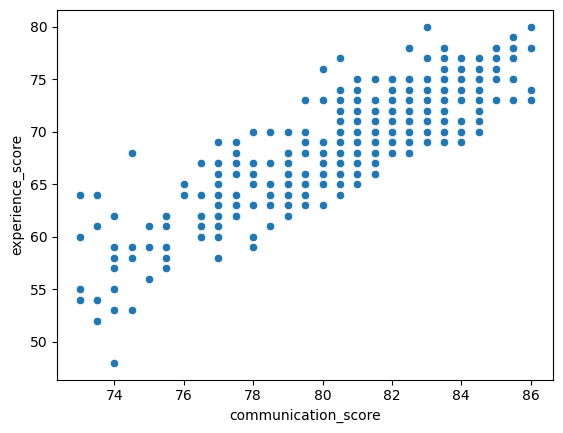

In [42]:
sns.scatterplot(
    data=state_pivot,
    x="communication_score",
    y="experience_score"
)

### 6. Does recommendation plateau after a point?

<Axes: xlabel='communication_score', ylabel='recommend_hospital'>

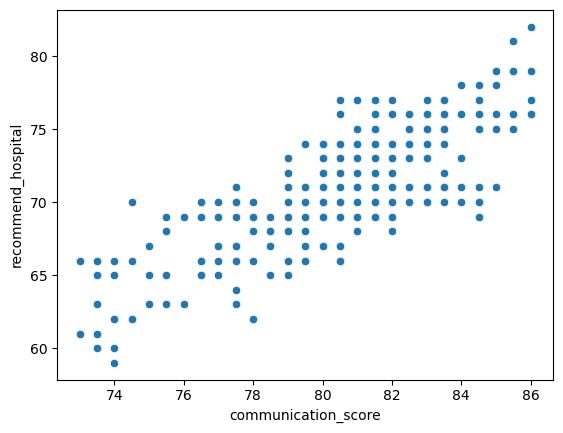

In [43]:
sns.scatterplot(
    data=state_pivot,
    x="communication_score",
    y="recommend_hospital"
)

### 7. Are composite KPIs more informative than individual metrics?

In [44]:
state_pivot.sort_values("executive_satisfaction_index").head(10)

measure_id,state,release_period,nurse_communication,doctor_communication,staff_responsiveness,recommend_hospital,communication_score,experience_score,executive_satisfaction_index
71,DC,07_2023,70.0,78.0,48.0,59.0,74.0,48.0,61.30
64,DC,07_2016,70.0,77.0,52.0,60.0,73.5,52.0,62.45
65,DC,07_2017,71.0,77.0,53.0,60.0,74.0,53.0,62.80
67,DC,07_2019,70.0,76.0,54.0,61.0,73.0,54.0,63.20
63,DC,07_2015,70.0,77.0,54.0,61.0,73.5,54.0,63.35
68,DC,07_2020,70.0,76.0,55.0,61.0,73.0,55.0,63.40
66,DC,07_2018,71.0,76.0,52.0,63.0,73.5,52.0,63.95
70,DC,07_2022,71.0,78.0,53.0,62.0,74.5,53.0,63.95
286,NJ,07_2023,74.0,74.0,55.0,62.0,74.0,55.0,64.20
69,DC,07_2021,71.0,77.0,57.0,62.0,74.0,57.0,64.60


In [46]:
state_pivot.to_csv('hcahps_state_pivot.csv', index=False)

## Database Connection

In [48]:
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="healthcare_DB"
)

print("Connection Successfull!")

cursor = conn.cursor()

Connection Successfull!


In [51]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://root:@localhost/healthcare_DB')

# Load data into MYSQL
state_pivot.to_sql('hcahps_state_satisfaction', con=engine, if_exists='replace', index=False)

print('Data successfully imported into MYSQL')

Data successfully imported into MYSQL
